<a href="https://colab.research.google.com/github/weicuivt/DL2019Fall/blob/master/HW2/ECE_CS_6524_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE-6524 / CS-6524 Deep Learning
# Assignment 2

In this assignment, **you need to complete the following three sectoins**:
1. PyTorch Basics
    - Toy example with PyTorch
2. Image Classification with PyTorch
    - Implement a simple MLP network for image classification
    - Implement a convolutional network for image classification
    - Experiment with different numbers of layers and optimizers
    - Push the performance of your CNN

This assignment is inspired and adopted from the official PyTorch tutorial.
## Submission guideline

1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are displayed correctly there. 
7. Zip the all the files along with this notebook (Please don't include the data)
8. Name your PDF file as Assignment2_[YOUR ID NUMBER].
9. Submit your zipped file and the PDF **INDEPENDENTLY**.

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

### Please Write Your VT PID Here: 905808996
### Reference (if any):

In this homework, you would need to use **Python 3.6+** along with the following packages:
```
1. pytorch 1.2
2. torchvision
3. numpy
4. matplotlib
```
To install pytorch, please follow the instructions on the [Official website](https://pytorch.org/). In addition, the [official document](https://pytorch.org/docs/stable/) could be very helpful when you want to find certain functionalities. 



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Assignment_2
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Assignment_2
 Assignment2_905808996.zip   data  'ECE-CS 6524 - Assignment 2.ipynb'


# Section 1. PyTorch Basics [30 pts]

Simply put, PyTorch is a **Tensor** library like Numpy. These two libraries similarly provide useful and efficient APIs for you to deal with your tensor data. What really differentiate PyTorch from Numpy are the following two features:
1. Numerical operations that can **run on GPUs** (more than 10x speedup)
2. Automatic differentiation for building and training neural networks

In this section, we will walk through some simple example, and see how the automatic differentiation functionality can make your life much easier.

## 1.1. Automatic Differentiation
Gradient descent is the driving force of the deep learning field. In the lectures and assignment 1, we learned how to derive the gradient for a given function, and implement methods for calculating and performing gradient descents. We also see how we can manually implement the backward and forward functions for the simple NN example. While implementing these functions may not be a big deal for a small network, it may get very nasty when we want to build something with tens of hundreds of layers.

In PyTorch (as well as other major deep learning libraries), we can use autograd ([automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation)) to handle the tedious computation of backward passes. When doing forward passes with autograd, we are essentially defining a **computational graph**, while the nodes in the graph are **tensors**, the edges are the functions that produce output tensors (e.g. ReLU, Linear, Convolutional Layer) given the input tensors. To do backpropagation, we can simply backtrack through this graph to compute gradients. 

This may sound a little bit abstract, so let's take a look at the example:

In [ ]:
import torch # import pytorch.

target = 10.

# create a matrix of size 2x2. Each with value draws from standard normal distribution.
x = torch.randn(2, 2, requires_grad=True) 
y = torch.randn(2, 2, requires_grad=True)

a = x + y
b = a.sum()
loss = b - target

# print out each tensor:
print(x)
print(y)
print(a)
print(b)
print(loss)

print("-----gradient-----")
print(x.grad)
print(y.grad)

tensor([[-0.6025, -0.6463],
        [-0.1990,  0.5098]], requires_grad=True)
tensor([[-0.4679, -0.8833],
        [-1.7347, -0.5699]], requires_grad=True)
tensor([[-1.0704, -1.5295],
        [-1.9337, -0.0601]], grad_fn=<AddBackward0>)
tensor(-4.5937, grad_fn=<SumBackward0>)
tensor(-14.5937, grad_fn=<SubBackward0>)
-----gradient-----
None
None


In the above example, we have seen a few things:
1. `requires_grad` flag: If false, we can safely exclude this tensor (and its subgraph) from gradient computation and therefore increase efficiency.
2. `grad_fn`: we can see that once an operation is done to a tensor, the output tensor is bound to a backward function associated to the operation. In this case, we have Add, Sum, and Sub.

However, even if we set `requires_grad=True`, we still don't have gradient for `x` and `y`. This is because that we haven't performed the backpropagation yet. So let's do it:

In [ ]:
# perform backpropagation from this "node"
loss.backward()
print('-----gradient-----')
print(x.grad)
print(y.grad)

-----gradient-----
tensor([[1., 1.],
        [1., 1.]])
tensor([[1., 1.],
        [1., 1.]])


Great, seems like we can perform gradient descent without writing backwards function! Now, let's see a simple toy example on how we can fit some weights `w1` and `w2` with random input `x` and target `y`: 

In [ ]:
dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold input and outputs.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Tensors during the backward pass.
x = torch.randn(N, D_in, device=device, dtype=dtype)
y = torch.randn(N, D_out, device=device, dtype=dtype)

# Create random Tensors for weights.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Tensors during the backward pass.
w1 = torch.randn(D_in, H, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(H, D_out, device=device, dtype=dtype, requires_grad=True)

learning_rate = 1e-6
for t in range(500):
    # Forward pass: compute predicted y using operations on Tensors; these
    # are exactly the same operations we used to compute the forward pass using
    # Tensors, but we do not need to keep references to intermediate values since
    # we are not implementing the backward pass by hand.
    y_pred = x.mm(w1).clamp(min=0).mm(w2)

    # Compute and print loss using operations on Tensors.
    # Now loss is a Tensor of shape (1,)
    # loss.item() gets the scalar value held in the loss.
    loss = (y_pred - y).pow(2).sum()
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')
    # Use autograd to compute the backward pass. This call will compute the
    # gradient of loss with respect to all Tensors with requires_grad=True.
    # After this call w1.grad and w2.grad will be Tensors holding the gradient
    # of the loss with respect to w1 and w2 respectively.
    loss.backward()

    # Manually update weights using gradient descent. Wrap in torch.no_grad()
    # because weights have requires_grad=True, but we don't need to track this
    # in autograd.  (because we don't need the gradient for the operation 
    # learning_rate * w1.grad)
    # An alternative way is to operate on weight.data and weight.grad.data.
    # Recall that tensor.data gives a tensor that shares the storage with
    # tensor, but doesn't track history.
    # You can also use torch.optim.SGD to achieve this.
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad

        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

iteration 99: 871.6419677734375
iteration 199: 9.039835929870605
iteration 299: 0.12880882620811462
iteration 399: 0.002259192056953907
iteration 499: 0.00016256274830084294


## 1.2. `nn` Module
Computational graphs and autograd are a very powerful paradigm for defining complex operators and automatically taking derivatives; however for large neural networks raw autograd can be a bit too low-level.

When building neural networks we frequently think of arranging the computation into layers, some of which have learnable parameters which will be optimized during learning.

In PyTorch, the nn package serves this purpose. The nn package defines a set of Modules, which are roughly equivalent to neural network layers. A Module receives input Tensors and computes output Tensors, but may also hold internal state such as Tensors containing learnable parameters. The nn package also defines a set of useful loss functions that are commonly used when training neural networks.

Now, let's see how our simple NN could be implemented using the nn module.

In [ ]:
import torch.nn as nn
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = nn.MSELoss(reduction='sum')

learning_rate = 1e-4
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero the gradients before running the backward pass.
    model.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

iteration 99: 2.681800127029419
iteration 199: 0.0444968044757843
iteration 299: 0.0013897938188165426
iteration 399: 5.530680937226862e-05
iteration 499: 2.3638890525035094e-06


So far, we have been updating the model parameters manually with `torch.no_grad()`. However, if we want to use optimization algorithms other than SGD, it might get a bit nasty to do it manually. Instead of manually doing this, we can use `optim` pacakge to help optimize our model: 

In [ ]:
x = torch.randn(5,3)
print(x)

tensor([[-0.7430, -0.0024,  0.2844],
        [ 1.9516,  0.5675,  2.3156],
        [ 0.6972, -1.4555,  2.1397],
        [-1.6965,  0.0881,  0.1323],
        [ 1.5326,  0.6526,  0.8175]])


In [ ]:
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Use the nn package to define our model and loss function.
model = nn.Sequential(
    nn.Linear(D_in, H),
    nn.ReLU(),
    nn.Linear(H, D_out),
)
loss_fn = torch.nn.MSELoss(reduction='sum')

# Use the optim package to define an Optimizer that will update the weights of
# the model for us. 
learning_rate = 1e-4
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x)

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

iteration 99: 2.9050896167755127
iteration 199: 0.05743909254670143
iteration 299: 0.0017912393668666482
iteration 399: 6.933413533261046e-05
iteration 499: 3.028186938536237e-06


Sometimes you will want to specify models that are more complex than a sequence of existing Modules; for these cases you can define your own Modules by subclassing nn.Module and defining a forward which receives input Tensors and produces output Tensors using other modules or other autograd operations on Tensors.

For example, we can implement our 2-layer simple NN as the following:

In [ ]:
class TwoLayerNet(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(TwoLayerNet, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    def forward(self, x):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred


# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N, D_in, H, D_out = 64, 1000, 100, 10

# Create random Tensors to hold inputs and outputs
x = torch.randn(N, D_in)
y = torch.randn(N, D_out)

# Construct our model by instantiating the class defined above
model = TwoLayerNet(D_in, H, D_out)

# Construct our loss function and an Optimizer. The call to model.parameters()
# in the SGD constructor will contain the learnable parameters of the two
# nn.Linear modules which are members of the model.
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
for t in range(500):
    # Forward pass: Compute predicted y by passing x to the model
    y_pred = model(x)

    # Compute and print loss
    loss = criterion(y_pred, y)
    if t % 100 == 99:
        print(f'iteration {t}: {loss.item()}')

    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

iteration 99: 2.4881346225738525
iteration 199: 0.035798005759716034
iteration 299: 0.0009966156212612987
iteration 399: 3.5246514016762376e-05
iteration 499: 1.437473542864609e-06


## 1.3. Warm-up: Two-moon datasets [30 pts]
Now, let's use PyTorch to solve some synthetic datasets. In previous assignment, we have to write some codes to create training batches. Again, this can also be done with PyTorch `DataLoader`. The `DataLoader` utilizes parallel workers to read and prepare batches for you, which can greatly speedup the code when your time bottleneck is on file I/O.

Here, we show a simple example that can create a dataloader from numpy data:

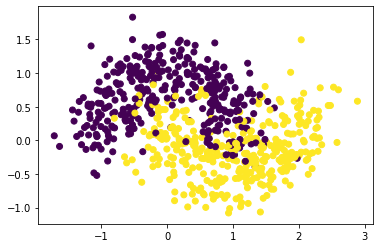

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_train = np.loadtxt('data/X1_train.csv', delimiter=',')
X_test = np.loadtxt('data/X1_test.csv', delimiter=',')
y_train = np.loadtxt('data/y1_train.csv', delimiter=',')
y_test = np.loadtxt('data/y1_test.csv', delimiter=',')

# Plot it to see why is it called two-moon dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);


Now, let's create a PyTorch `DataLoader`:

In [ ]:
X_train[1:20]

array([[ 2.89013901,  0.5816847 ],
       [ 0.64305663, -0.23076991],
       [ 2.2593771 ,  0.17801536],
       [ 0.70935303, -0.24496862],
       [ 2.52702369,  0.79073014],
       [-0.1939462 ,  0.17343962],
       [ 0.75113042, -0.68284778],
       [ 0.52534017,  0.04206378],
       [-0.2928505 ,  0.73368353],
       [ 0.10902716,  0.76213182],
       [ 1.26130092,  0.76238866],
       [ 1.55024077, -0.49602774],
       [-0.09640985,  0.11684894],
       [-0.52536158,  0.23001757],
       [-0.06270236,  1.15464036],
       [ 1.02358656, -0.21639312],
       [-1.25397045,  0.19121425],
       [-1.04405948, -0.07309302],
       [ 0.12562716,  1.00263207]])

In [ ]:
y_train[1:20]

array([1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0.])

In [ ]:
train_dataset[1:10]

(tensor([[ 2.8901,  0.5817],
         [ 0.6431, -0.2308],
         [ 2.2594,  0.1780],
         [ 0.7094, -0.2450],
         [ 2.5270,  0.7907],
         [-0.1939,  0.1734],
         [ 0.7511, -0.6828],
         [ 0.5253,  0.0421],
         [-0.2929,  0.7337]]), tensor([[1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [1],
         [0]]))

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64 # mini-batch size
num_workers = 4 # how many parallel workers are we gonna use for reading data
shuffle = True # shuffle the dataset

# Convert numpy array import torch tensor
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.reshape(-1, 1))
y_test = torch.LongTensor(y_test.reshape(-1, 1))

# First, create a dataset from torch tensor. A dataset define how to read data
# and process data for creating mini-batches.
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                          num_workers=num_workers, shuffle=shuffle)

Below, we provide a simple example on how to train your model with this dataloader:

In [ ]:
epoch = 5 # an epoch means looping through all the data in the datasets
lr = 1e-1

# create a simple model that is probably not gonna work well
model = nn.Linear(X_train.size(1), 1)
optim = torch.optim.SGD(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    # loop through train loader to get x and y
    for x, y in train_loader:
        optim.zero_grad()
        y_pred = model(x)
        # !!WARNING!!
        # THIS IS A CLASSIFICATION TASK, SO YOU SHOULD NOT
        # USE THIS LOSS FUNCTION. 
        loss = (y_pred - y.float()).abs().mean()
        loss.backward()
        optim.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')

Epcoh 0: 5.814182370901108
Epcoh 1: 2.9536602795124054
Epcoh 2: 2.906713977456093
Epcoh 3: 2.8909642547369003
Epcoh 4: 2.8859013468027115


### 1.3.1 Your Simple NN [30 pts]
Now, it is time for you to implement your own model for this classification task. Your job here is to:
1. Complete the SimpleNN class. It should be a 2- or 3-layer NN with proper non-linearity.
2. Train your model with SGD optimizer.
3. Tune your model a bit so you can achieve at least 80% accuracy on training set.
Hint: you might want to look up `nn.ReLU`, `nn.Sigmoid`, `nn.BCELoss` in the [official document](https://pytorch.org/docs/stable/). You are allowed to freely pick the hyperparameters of your model.

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        # super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # feed the input to your network, and output the predictions.                  #
        ################################################################################
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
    
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        

In [ ]:
# an epoch means looping through all the data in the datasets
epoch = 10
lr = 1e-1

# create a simple model that is probably not gonna work well

################################################################################
# TODO:                                                                        #
# Initialize your model and SGD optimizer here.                                #
################################################################################

D_in, H, D_out = X_train.size(1), 10, 1

model = SimpleNN(D_in, H, D_out)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss(reduction='mean')


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


for e in range(epoch):
    loss_epoch = 0
    ################################################################################
    # TODO:                                                                        #
    # Loop through the dataloader and train your model with nn.BCELoss.            #
    ################################################################################
    
    for x, y in train_loader:
        y_pred = model.forward(x)
        loss = (y_pred - y.float()).abs().mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')
    
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

Epcoh 0: 2.1046195328235626
Epcoh 1: 1.6465306729078293
Epcoh 2: 1.533525288105011
Epcoh 3: 1.4887716695666313
Epcoh 4: 1.449838064610958
Epcoh 5: 1.4225691184401512
Epcoh 6: 1.401479311287403
Epcoh 7: 1.40322595089674
Epcoh 8: 1.41878142952919
Epcoh 9: 1.3780907317996025


In [ ]:
# helper function for computing accuracy
def get_acc(pred, y):
    pred = pred.float()
    y = y.float()
    return (y==pred).sum().float()/y.size(0)*100.

Evaluate your accuracy:

In [ ]:
y_pred = (model.forward(X_train) > 0.5)
train_acc = get_acc(y_pred, y_train)

y_pred = (model.forward(X_test) > 0.5)
test_acc = get_acc(y_pred, y_test)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

Training accuracy: 84.28571319580078, Testing accuracy: 83.33332824707031


In [ ]:
# Summary: 
# Train: 700; Test: 300
# Input: 2 (ex: [-0.7121,  0.6950])     Output: 1 (ex: 0 or 1)
# Architecture: 2-layers NN with 10 hidden nodes
# Activation function: ReLU
# Optimization: SGD 
# Loss function: MSELoss
# Hyperparameter: epoch = 10,learning rate: lr = 1e-1
# This simple NN acheives over 80% accuracy for both train and test dataset

# Section 2. Image Classification with CNN [70 pts]
Now, we are back to the image classification problem. In this section, our goal is to, again, train models on CIFAR-10 to perform image classification. Your tasks here are to:
1. Build and Train a simple feed-forward Neural Network (consists of only nn.Linear layer with activation function) for the classification task
2. Build and Train a **Convolutional** Neural Network (CNN) for the classification task
3. Try different settings for training your CNN
4. Reproduce

In the following cell, we provide the code for creating a CIFAR10 dataloader. As you can see, PyTorch's `torchvision` package actually has an interface for the CIFAR10 dataset: 

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Preprocessing steps on the training/testing data. You can define your own data augmentation
# here, and PyTorch's API will do the rest for you.
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# This will automatically download the dataset for you if it cannot find the data in root
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## 2.1 Simple NN [30 pts]
Implement a simple feed-forward neural network, and train it on the CIFAR-10 training set. Here's some specific requirements:
1. The network should only consists of `nn.Linear` layers and the activation functions of your choices (e.g. `nn.Tanh`, `nn.ReLU`, `nn.Sigmoid`, etc). 
2. Train your model with `torch.optim.SGD` with the hyperparameters you like the most. 

Note that the hyperparameters work in previous assignment might not work the same, as the implementations of layers could be different.

In [ ]:
class SimpleNN(nn.Module):
    
    def __init__(self, D_in, H, D_out):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Construct your small feedforward NN here.                                    #
        ################################################################################
        super(SimpleNN, self).__init__()
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
    def forward(self, x):
        # note that: here, the data is of the shape (B, C, H, W)
        # where B is the batch size, C is color channels, and H
        # and W is height and width.
        # To feed it into the linear layer, we need to reshape it
        # with .view() function.
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # reshape the data from (B, C, H, W) to (B, C*H*W)
        ################################################################################
        # TODO:                                                                        #
        # Forward pass, output the prediction score.                                   #
        ################################################################################
        h_relu = self.linear1(x).clamp(min=0)
        y_pred = self.linear2(h_relu)
        return y_pred
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

H = 100
model = SimpleNN(n_input, H, n_classes)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()


for e in range(epoch):
    loss_epoch = 0
    for x, y in train_loader:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')


################################################################################
#                                 END OF YOUR CODE                             #
################################################################################


Epcoh 0: 1354.4918031692505
Epcoh 1: 1208.396605372429
Epcoh 2: 1145.9103227853775
Epcoh 3: 1099.5618304014206
Epcoh 4: 1063.9656347036362
Epcoh 5: 1034.5730928182602
Epcoh 6: 1007.9670815467834
Epcoh 7: 984.9500880241394
Epcoh 8: 964.326208293438
Epcoh 9: 946.5294954776764


Now evaluate your model with the helper function:

In [ ]:
def get_model_acc(model, loader):
    ys = []
    y_preds = []
    for x, y in loader:
        ys.append(y)
        # set the prediction to the one that has highest value
        # Note that the the output size of model(x) is (B, 10)
        y_preds.append(torch.argmax(model(x), dim=1))
    y = torch.cat(ys, dim=0)
    y_pred = torch.cat(y_preds, dim=0)
    print((y == y_pred).sum())
    return get_acc(y_pred, y)

### 2.1.1 Evaluate NN [30 pts]
Evaluate your NN. You should get an accuracy around **50%** on training set and **49%** on testing set.

In [ ]:
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(28675)
tensor(4919)
Training accuracy: 57.349998474121094, Testing accuracy: 49.189998626708984


In [ ]:
# Summary: 
# Input: 3072      Output: 10
# Architecture: 2-layers NN with 100 hidden nodes
# Activation function: ReLU
# Optimization: SGD 
# Loss function: CrossEntropyLoss
# Hyperparameter: epoch = 10,learning rate: lr = 1e-1; batch size: 64
# This simple NN acheives accuracy around 50% on training set and 49% on testing set.

## 2.2 Convolutional Neural Network (CNN) [40 pts]
Convolutional layer has been proven to be extremely useful for vision-based task. As mentioned in the lecture, this speical layer allows the model to learn filters that capture crucial visual features. 



### 2.2.1 Implement and Evaluate CNN [10 pts]
In this section, you will need to construct a CNN for classifying CIFAR-10 image. Specifically, you need to:
1. build a `CNNClassifier` with `nn.Conv2d`, `nn.Maxpool2d` and activation functions that you think are appropriate. 
2. You would need to flatten the output of your convolutional networks with `view()`, and feed it into a `nn.Linear` layer to predict the class labels of the input. 

Once you are done with your module, train it with `optim.SGD`, and evaluate it. You should get an accuracy around **55%** on training set and **53%** on testing set.

Hint: You might want to look up `nn.Conv2d`, `nn.Maxpool2d`, `nn.CrossEntropyLoss()`, `view()` and `size()`.

In [ ]:
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    
    def __init__(self,in_channel, out_channel, filter_size):
        ################################################################################
        # TODO:                                                                        #
        # Construct a CNN with 2 or 3 convolutional layers and 1 linear layer for      #
        # outputing class prediction. You are free to pick the hyperparameters         #
        ################################################################################
        
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, 15, filter_size)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(15, 12, filter_size)
        self.linear1=nn.Linear(12 * 10 * 10, out_channel)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################
        
        
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Forward pass of your network. First extract feature with CNN, and predict    #
        # class scores with linear layer. Be careful about your input/output shape.    #
        ################################################################################
        
        # print(x.size())
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.conv2(x)
        x = x.view(-1, 12* 10 * 10)
        return self.linear1(x)
        
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

In [ ]:
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

model = CNNClassifier(3,10,5)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

for e in range(epoch):
    loss_epoch = 0
    for x, y in train_loader:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')
    

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1327.052695274353
Epcoh 1: 1086.5805433988571
Epcoh 2: 1017.3189124464989
Epcoh 3: 961.9801934957504
Epcoh 4: 913.0858766436577
Epcoh 5: 876.5575193762779
Epcoh 6: 853.1251313686371
Epcoh 7: 836.4923467040062
Epcoh 8: 822.2498172521591
Epcoh 9: 809.7935128211975


In [ ]:
# turn on evaluation mode. This is crucial when you have BatchNorm in your network,
# as you want to use the running mean/std you obtain durining training time to normalize
# your input data. Rememeber to call .train() function after evaluation
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

tensor(31076)
tensor(5970)
Training accuracy: 62.15199661254883, Testing accuracy: 59.70000076293945


<span style="color:red">**Explain your design and hyperparameter choice in three or four sentences:**</span>

Design: 
    The network contains 2 convolutional layers and 1 max pooling layer. 
    The input channel is 3; Middle channel is 15; Output channel is 10;
    Filter size is 5. Stride=1. Pooling size is 2. No padding.
    Optimization: SGD
    Loss function: CrossEntropyLoss
    
Hyperparameter:
    epoch = 10
    lr = 1e-2
    batch_size = 64
    
Results:
    This simple CNN acheives accuracy around 62% on training set and 59% on testing set. 
    I made this chocie because it can give me best accuracy by trail and error. 
    Also, the CNN is simple enough for my laptop to run. 

### 2.2.2 STACK MORE LAYERS [10 pts]
Now, **try at least 4 network architectures with different numbers of convolutional layers**. Train these settings with `optim.SGD`, plot the accuracy as a fuction of convolutional layers and describe what you have observed (running time, performance, etc). 

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################
import torch.nn.functional as F
## 1-layer CNN
%time
class CNNLayer1(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNNLayer1,self).__init__()
        #Create 1st layer
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=5)
        self.linear = nn.Linear(in_features=8*28*28,out_features=out_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1,8*28*28)
        return self.linear(x)

##  2-layer CNN
class CNNLayer2(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNNLayer2,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5)
        self.linear = nn.Linear(in_features=8*10*10,out_features=out_channels)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = x.view(-1,8*10*10)
        return self.linear(x)

##  3-layer CNN
class CNNLayer3(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNNLayer3,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5)
        self.linear = nn.Linear(in_features=8*6*6,out_features=out_channels)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = x.view(-1,8*6*6)
        return self.linear(x)

##  4-layer CNN
class CNNLayer4(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(CNNLayer4,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels,out_channels=8,kernel_size=5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5)
        self.conv4 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=5)
        self.linear = nn.Linear(in_features=8*2*2,out_features=out_channels)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.conv4(x)
        x = x.view(-1,8*2*2)
        return self.linear(x)

# Train the CNN 
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNLayer4(3,10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()


for e in range(epoch):
    loss_epoch = 0
    for x, y in train_loader:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')

model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

    
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 5.96 µs
Epcoh 0: 1688.572285413742
Epcoh 1: 1465.2414149045944
Epcoh 2: 1329.496152639389
Epcoh 3: 1235.3316926956177
Epcoh 4: 1171.414178609848
Epcoh 5: 1134.991012096405
Epcoh 6: 1109.8472093343735
Epcoh 7: 1088.250674366951
Epcoh 8: 1070.494764149189
Epcoh 9: 1057.0194869041443
tensor(21749)
tensor(4253)
Training accuracy: 43.49800109863281, Testing accuracy: 42.529998779296875


In [ ]:
1-layer CNN Output: 
Epcoh 0: 1406.8942036628723
Epcoh 1: 1355.0191254615784
Epcoh 2: 1339.4922153949738
Epcoh 3: 1330.805212855339
Epcoh 4: 1322.5252001285553
Epcoh 5: 1316.581095457077
Epcoh 6: 1310.009941458702
Epcoh 7: 1306.171748161316
Epcoh 8: 1300.480077624321
Epcoh 9: 1297.2553458213806
tensor(21127)
tensor(3712)
Training accuracy: 42.25400161743164, Testing accuracy: 37.119998931884766

2-layer CNN Output: 
Epcoh 0: 1373.0496850013733
Epcoh 1: 1151.033370733261
Epcoh 2: 1078.3630838990211
Epcoh 3: 1029.7335131168365
Epcoh 4: 993.3573430776596
Epcoh 5: 970.7726957201958
Epcoh 6: 949.9841889739037
Epcoh 7: 932.6380230784416
Epcoh 8: 919.5890220403671
Epcoh 9: 908.4062338471413
tensor(29063)
tensor(5608)
Training accuracy: 58.12600326538086, Testing accuracy: 56.08000183105469
        
3-layer CNN Output:
Epcoh 0: 1563.753846168518
Epcoh 1: 1286.564388513565
Epcoh 2: 1192.53229367733
Epcoh 3: 1132.1954835653305
Epcoh 4: 1090.5051774382591
Epcoh 5: 1052.856717467308
Epcoh 6: 1027.9334802031517
Epcoh 7: 1007.6736091971397
Epcoh 8: 991.900506913662
Epcoh 9: 978.280636370182
tensor(27850)
tensor(5453)
Training accuracy: 55.69999694824219, Testing accuracy: 54.529998779296875
        
4-layer CNN Output:
Epcoh 0: 1688.572285413742
Epcoh 1: 1465.2414149045944
Epcoh 2: 1329.496152639389
Epcoh 3: 1235.3316926956177
Epcoh 4: 1171.414178609848
Epcoh 5: 1134.991012096405
Epcoh 6: 1109.8472093343735
Epcoh 7: 1088.250674366951
Epcoh 8: 1070.494764149189
Epcoh 9: 1057.0194869041443
tensor(21749)
tensor(4253)
Training accuracy: 43.49800109863281, Testing accuracy: 42.529998779296875

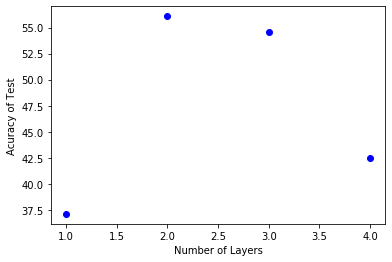

In [ ]:
# Plot the result: 
layer_list=[1,2,3,4]
acu_list=[37.119998931884766,56.08000183105469,54.529998779296875,42.529998779296875]
plt.plot(layer_list,acu_list,'bo');
plt.ylabel('Acuracy of Test');
plt.xlabel('Number of Layers');

<span style="color:red">**Briefly explain what you have observed in three or four sentences. Does stacking layers always give you better results? How about the computational time?:**</span>

In [ ]:
The accuracy increases at first and then decreases when we increase the number of layers. 
It does not always give better result by stacking more layers.
We find that it takes more computational time to train CNN with more layers. 

### 2.2.3 Optimizer? Optimizer! [10 pts]
So far, we only use SGD as our optimizer. Now, pick two other optimizers, train your CNN models, and compare the performance you get. What did you see?

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

import torch.optim as Opt
# You can tune these hyperparameters as you like.
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = CNNLayer2(3,10)
loss_fn = nn.CrossEntropyLoss()

# choose different optimizers:
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

for e in range(epoch):
    loss_epoch = 0
    for x, y in train_loader:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')
    
model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

Epcoh 0: 1646.5864316225052
Epcoh 1: 1508.3467164039612
Epcoh 2: 1446.6222896575928
Epcoh 3: 1390.4752886295319
Epcoh 4: 1336.2126928567886
Epcoh 5: 1288.947086572647
Epcoh 6: 1251.0049463510513
Epcoh 7: 1222.1448757648468
Epcoh 8: 1198.5986899137497
Epcoh 9: 1179.6359493732452
tensor(23476)
tensor(4713)
Training accuracy: 46.95199966430664, Testing accuracy: 47.130001068115234


In [ ]:
SDG output: 
Epcoh 0: 1373.0496850013733
Epcoh 1: 1151.033370733261
Epcoh 2: 1078.3630838990211
Epcoh 3: 1029.7335131168365
Epcoh 4: 993.3573430776596
Epcoh 5: 970.7726957201958
Epcoh 6: 949.9841889739037
Epcoh 7: 932.6380230784416
Epcoh 8: 919.5890220403671
Epcoh 9: 908.4062338471413
tensor(29063)
tensor(5608)
Training accuracy: 58.12600326538086, Testing accuracy: 56.08000183105469

Adam output:
Epcoh 0: 1411.3866897821426
Epcoh 1: 1331.034428358078
Epcoh 2: 1373.3354017734528
Epcoh 3: 1349.5545563697815
Epcoh 4: 1343.59157538414
Epcoh 5: 1359.3811277151108
Epcoh 6: 1352.0158956050873
Epcoh 7: 1347.3744359016418
Epcoh 8: 1360.8486785888672
Epcoh 9: 1332.8903744220734
tensor(19177)
tensor(3639)
Training accuracy: 38.354000091552734, Testing accuracy: 36.38999938964844
        
Adadelta output: 
Epcoh 0: 1646.5864316225052
Epcoh 1: 1508.3467164039612
Epcoh 2: 1446.6222896575928
Epcoh 3: 1390.4752886295319
Epcoh 4: 1336.2126928567886
Epcoh 5: 1288.947086572647
Epcoh 6: 1251.0049463510513
Epcoh 7: 1222.1448757648468
Epcoh 8: 1198.5986899137497
Epcoh 9: 1179.6359493732452
tensor(23476)
tensor(4713)
Training accuracy: 46.95199966430664, Testing accuracy: 47.130001068115234

<span style="color:red">**What did you see? Which optimizer is your favorite? Describe:**</span>

I train the same CNN with three different optimization algorithms, SGD, Adam and Adadelta. 
From our results, SGD performs best, then Adadelta and Adam. 
My favorite one is SGD.

### 2.2.4 Improve Your Model [10 pts]
Again, we want you to play with your model a bit harder, and improve it. You are free to use everything you can find in the documents (`BatchNorm`, `SeLU`, etc), as long as it is not a **predefined network architectures in PyTorch package**. You can also implement some famous network architectures to push the performance. 

(A simple network with 5-6 `nn.Conv2d` can give you at least 70% accuracy on testing set).

In [ ]:
################################################################################
# TODO:                                                                        #
# Your training code here.                                                     #
################################################################################

class ConvBatSeLu(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(ConvBatSeLu,self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,out_channels=out_channels,kernel_size=5)
        self.bn = nn.BatchNorm2d(num_features=out_channels)

    def forward(self,input):
        output = self.conv(input)
        output = self.bn(output)
        output = F.selu(output)
        return output


class MyBestCNN(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(MyBestCNN,self).__init__()
        self.conv1 = ConvBatSeLu(in_channels=in_channels,out_channels=16)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = ConvBatSeLu(in_channels=16,out_channels=16)
        self.linear = nn.Linear(in_features=16*10*10,out_features=out_channels)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = x.view(-1,16*10*10)
        return self.linear(x)


# Train the CNN 
epoch = 10
lr = 1e-2
n_input = 3072
n_classes = 10
batch_size = 64
num_workers = 2

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

model = MyBestCNN(3,10)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()


for e in range(epoch):
    loss_epoch = 0
    for x, y in train_loader:
        y_pred = model.forward(x)
        loss = loss_fn(y_pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    print(f'Epcoh {e}: {loss_epoch}')

model.eval()
train_acc = get_model_acc(model, train_loader)
test_acc = get_model_acc(model, test_loader)
print(f'Training accuracy: {train_acc}, Testing accuracy: {test_acc}')

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

In [ ]:
# The result:

Epcoh 0: 1184.8225207328796
Epcoh 1: 963.2583043575287
Epcoh 2: 879.5836268663406
Epcoh 3: 831.4896352291107
Epcoh 4: 790.4476766586304
Epcoh 5: 761.3781149983406
Epcoh 6: 736.0012830495834
Epcoh 7: 717.3178885877132
Epcoh 8: 701.5758913755417
Epcoh 9: 686.2442553639412
tensor(33978)
tensor(6492)
Training accuracy: 67.95600128173828, Testing accuracy: 64.92000579833984

The CNN has 2 layers.The design and hyperparameter is the same with previous CNN, which has 55% accuracy on test dataset. Here, we make improvement by introducing batchnorm layer before each convolutional layers. Keeping all other things unchanged,we get a result with accuracy around 65% on test dataset. 